In [1]:
import numpy as np
from matplotlib import pyplot as plt

# 1. Прямая с шумом

Сгенерируем точки $(x_i, y_i)$ по закону
$$
    y = w_1 x + w_0 + \epsilon,
$$
где $\epsilon$ - случайная величина из нормального распределения, моделирующая разброс точек. 

Возьмем $\epsilon \sim \mathcal{N}(0, 0.3)$. 

In [2]:
true_w1 = 1.7
true_w0 = 2.3
print('True w:', true_w1, true_w0)

x_train = np.arange(1, 5, 0.2)
noise = np.random.normal(0, 0.3, size=x_train.shape)
y_train = x_train * true_w1 + true_w0 + noise
# [x * true_w1 + true_w0 for x in xs] -- BAD!

True w: 1.7 2.3


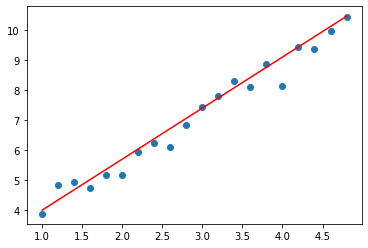

In [3]:
plt.scatter(x_train, y_train)
plt.plot(x_train, y_train - noise, c='r')
plt.show()

Применим формулы метода наименьших квадратов, выведенные на лекции:

$$
    \hat{w_1} = \sum_{i=1}^{l} \frac{(x_i - \bar{x})(y_i - \bar{y})} {(x_i - \bar{x})^2} = \frac{\hat{\text{cov}}(x, y)}{\hat{\text{var}} \, x}, \qquad \hat{w_0} = \bar{y} - \hat{w_1} \bar{x},
$$
где $\bar{x} = \frac{1}{l} \sum_{i=1}^{l} x_i$ и $\bar{y} = \frac{1}{l} \sum_{i=1}^{l} y_i$ - это средние по выборке.

Выборочные дисперсии и ковариация:
$$
    \hat{\text{var}} \, x = \frac{1}{l} \sum_{i=1}^{l} (x_i - \bar{x})^2 \qquad
    \hat{\text{var}} \, y = \frac{1}{l} \sum_{i=1}^{l} (y_i - \bar{y})^2 \qquad
    \hat{\text{cov}}(x, y) = \frac{1}{l} \sum_{i=1}^{l} (x_i - \bar{x})(y_i - \bar{y})
$$

In [4]:
var_x = np.mean((x_train - x_train.mean()) ** 2)
var_y = np.mean((y_train - y_train.mean()) ** 2)
cov_xy = np.mean((x_train - x_train.mean()) * (y_train - y_train.mean()))

(var_x, var_y, cov_xy)

(1.3299999999999994, 3.6865579000710555, 2.1845907221619623)

In [5]:
(np.var(x_train), np.var(y_train))

(1.3299999999999994, 3.6865579000710555)

In [6]:
np.cov([x_train, y_train], bias=True)

array([[1.33      , 2.18459072],
       [2.18459072, 3.6865579 ]])

In [7]:
(np.var(x_train), np.var(y_train), np.cov([x_train, y_train], bias=True)[0, 1])

(1.3299999999999994, 3.6865579000710555, 2.1845907221619623)

In [8]:
w1 = cov_xy / var_x
w0 = y_train.mean() - w1 * x_train.mean()

print('True w:', true_w1, true_w0)
print('Restored w:', w1, w0)

True w: 1.7 2.3
Restored w: 1.642549415159371 2.3220081073848418


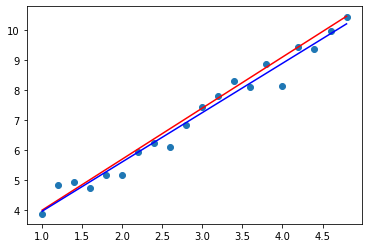

In [9]:
plt.scatter(x_train, y_train)
plt.plot(x_train, y_train - noise, c='r')
plt.plot(x_train, x_train * w1 + w0, c='b')
plt.show()

Посчитаем коэффицент линейной корреляции Пирсона:

$$
    r = \frac{\hat{\text{cov}}(x, y)}{\sqrt{ \hat{\text{var}} \, x \, \hat{\text{var}} \, y}}
$$

In [10]:
r = cov_xy / np.sqrt(var_x * var_y)
r

0.986583243143367

Воспользуемся формализмом матрицы объект-признак и решением МНК через псевдообратную матрицу.

В нашем случае (1D регрессия с учетом смещения $\check{y} = w_1 x + w_0$) имеем два признака: сам $x$ и постоянный признак $1$, отвечающий смещению.  
$$
    X = \begin{pmatrix}
        x_1 & 1 \\
        x_2 & 1 \\
        \dots & \dots \\
        x_l & 1
    \end{pmatrix} 
    \qquad
    y = \begin{pmatrix}
        y_1 \\
        y_2 \\
        \dots \\
        y_l
    \end{pmatrix} 
$$

In [11]:
x_train.shape

(20,)

In [12]:
X = x_train.reshape((-1, 1))
X = np.hstack([X, np.ones(X.shape)])
X.shape

(20, 2)

In [13]:
Q = np.linalg.inv(X.T @ X) @ X.T
np.round(Q @ X)

array([[1., 0.],
       [0., 1.]])

In [14]:
def left_pseudoinverse(X):
    return np.linalg.inv(X.T @ X) @ X.T

In [15]:
Q = left_pseudoinverse(X)
np.round(Q @ X)

array([[1., 0.],
       [0., 1.]])

In [16]:
w = Q @ y_train
w

array([1.64254942, 2.32200811])

Учесть систематическую погрешность $y_i \pm s$ можно при помощи усреднения по ансамблю выборок (приборов), рассматривая случайную величину $\tilde{y_i} \sim \mathcal{N}(y_i, s^2)$.

Тогда, как было показано на лекции, для дисперсии параметров модели (весов) получим
$$
    \text{var} \, w_\alpha = s^2 [(X^T X)^{-1}]_{\alpha \alpha}
$$
И оценкой погрешности будет
$$
    \text{погрешность} \, w_\alpha \approx \sqrt{\text{var} \, w_\alpha} = s \sqrt{[(X^T X)^{-1}]_{\alpha \alpha}}
$$


Для учета погрешности полезно вычислить матрицу $(X^T X)^{-1}$

In [17]:
XTXinv = np.linalg.inv(X.T @ X)

In [18]:
print('Погрешность параметров (w1, w0) = s * ', (np.sqrt(XTXinv[0, 0]), np.sqrt(XTXinv[1, 1])))

Погрешность параметров (w1, w0) = s *  (0.19389168358237013, 0.6051160331158263)


# 2. Регрессия рядом Тейлора

Зададим функцию 

Сгенерируем точки $(x_i, y_i)$ по закону
$$ y = \frac{e^{10x} \, sin(10x)}{10+(10x)^2+(10x)} \cdot \frac{1}{1+100x} + \epsilon $$
где $\epsilon$ - случайная величина из нормального распределения, моделирующая разброс точек. 
Пусть $\epsilon \sim \mathcal{N}(0, 0.03)$

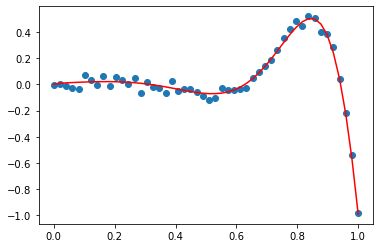

In [24]:
x_train = np.linspace(0, 1, 50).reshape((-1, 1))
noise = np.random.normal(0, 0.03, size=x_train.shape)
y_train = np.exp(10*x_train)*np.sin(10*x_train)/(10 + (10*x_train)**2 + (10*x_train))*1/(1+100*x_train) + noise

plt.scatter(x_train, y_train)
plt.plot(x_train, y_train - noise, c='r')
plt.show()

Постараемся найти аппроксимацию к данной кривой. Искать будем в виде суммы одночленов степени до M включительно методом линейной регрессии. Тогда матрица Объекты-Признаки должна выглядеть как

$$
\left(\begin{array}{ccccc}
1 & x_1 & x_1^2 & \ldots & x_1^M \\
1 & x_2 & x_2^2 & \ldots & x_2^M \\
\ldots & \ldots & \ldots & \ldots & \ldots \\
1 & x_N & x_N^2 & \ldots & x_N^M
\end{array}\right)
$$


(-1.0, 0.6)

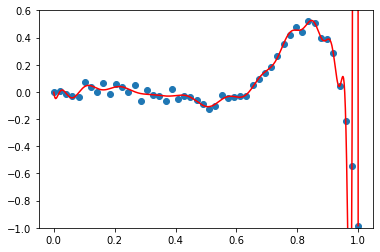

In [25]:
def x_pow_k(x, k):
    return x**k

def model_predict(x, w):
    deg = len(w) - 1
    
    X = np.ones(x.shape)

    for k in range(1, deg+1):
        X = np.concatenate([X, x_pow_k(x, k)], axis = 1)
        
    return X @ w

M = 50

X = np.ones(x_train.shape)

for k in range(1, M+1):
    X = np.concatenate([X, x_pow_k(x_train, k)], axis = 1)
    
# Вычисляем столбец коэффицентов регрессии

w = np.linalg.pinv(X) @ y_train

# Смотрим предсказания модели

x_dens = np.linspace(0, 1, 500).reshape((-1, 1))

plt.scatter(x_train, y_train)
plt.plot(x_dens, model_predict(x_dens, w), c="r")

plt.ylim([-1, 0.6])

Мы поняли, что при больших M модель становится хуже! Это называется переобучение. Построим график зависимости MSE Loss от степени фита M, чтобы понять, какая модель лучше.

In [26]:
def MSE(Y_predict, Y_label):
    return ((Y_predict - Y_label)**2).mean()

def Model(M, x_train, y_train):
    X = np.ones(x_train.shape)

    for k in range(1, M+1):
        X = np.concatenate([X, x_pow_k(x_train, k)], axis = 1)

    # Вычисляем столбец коэффицентов регрессии

    w = np.linalg.pinv(X) @ y_train

    # Смотрим предсказания модели

    y_predict = X @ w

    return y_predict

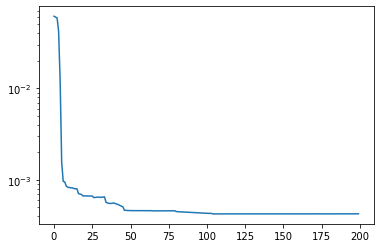

In [27]:
Ms = np.arange(0, 200, 1)
losses = [MSE(Model(m, x_train, y_train), y_train) for m in Ms]

plt.semilogy(Ms, losses)

Как же так? Предсказание всё лучше и лучше, а кривая просто ужасна!

Суть в том, что при обучении, модель как бы "выучивает" обучающую выборку, но никакой аппроксимирующей силы не имеет. 

Для решения вопроса о наилучшей модели необходимо часть исходной выборки пожерствовать на тестирование - на этой части мы будем проверять ошибку, а при обучении она использоваться не будет.

Minimum MSE = 0.0008481102003559865, with M = 8


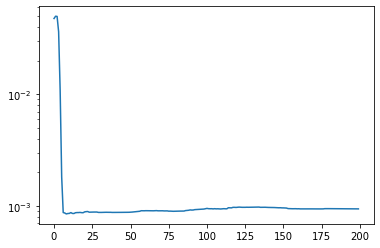

In [35]:
def Model_validation(M, x_train, y_train, x_to_predict):
    X = np.ones(x_train.shape)

    for k in range(1, M+1):
        X = np.concatenate([X, x_pow_k(x_train, k)], axis = 1)

    # Вычисляем столбец коэффицентов регрессии

    w = np.linalg.pinv(X) @ y_train

    # Смотрим предсказания модели

    X = np.ones(x_to_predict.shape)

    for k in range(1, M+1):
        X = np.concatenate([X, x_pow_k(x_to_predict, k)], axis = 1)
        
    y_predict = X @ w

    return y_predict

x = np.linspace(0, 1, 500).reshape((-1, 1))
noise = np.random.normal(0, 0.03, size=x.shape)
y = np.exp(10*x)*np.sin(10*x)/(10 + (10*x)**2 + (10*x))/(1+100*x) + noise


from sklearn import model_selection as ms
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.3)

Ms = np.arange(0, 200, 1)
losses = [MSE(Model_validation(m, x_train, y_train, x_test), y_test) for m in Ms]

plt.semilogy(Ms, losses)
print(f"Minimum MSE = {min(losses)}, with M = {np.argmin(losses)}")

А ещё лучше делать кроссвалидацию методом KFold - разбиваем всю выборку на K частей - на K-1 обучаем, на оставашейся делаем тест. Повторить, пока все элементы выборки не побывают в тесте, после чего выбрать наилучшую модель.

# 3. Линейная регрессия в sklearn


С помощью sklearn можно легко генерировать матрицу Объекты-Признаки со степенями

In [34]:
# PolynomialFeatures

x = np.arange(1, 5, 1).reshape((-1, 1))

from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(2)

# X = poly.fit_transform(x) 

# print(x)
# print(X)

# print(poly.get_feature_names_out()) # имена столбцов

print("-------------------")

#Также легко генерировать полиномиальный базис для больший размерностей изначального х

# x1 = np.arange(1, 5, 1).reshape((-1, 1))
# x2 = np.arange(-1, -5, -1).reshape((-1, 1))
# x = np.hstack([x1, x2])

# print(x1)
# print()
# print(x2)
# print()
# print(x)
# print()

poly = PolynomialFeatures(5)

X = poly.fit_transform(x) 

# print(x)
# print(X)

print(poly.get_feature_names_out()) # имена столбцов

x = np.linspace(0, 1, 500).reshape((-1, 1))
noise = np.random.normal(0, 0.03, size=x.shape)
y = np.exp(10*x)*np.sin(10*x)/(10 + (10*x)**2 + (10*x))/(1+100*x) + noise


from sklearn import model_selection as ms
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.3)

Ms = np.arange(0, 200, 1)
losses = [MSE(Model_validation(m, x_train, y_train, x_test), y_test) for m in Ms]

plt.semilogy(Ms, losses)
print(f"Minimum MSE = {min(losses)}, with M = {np.argmin(losses)}")

[[1]
 [2]
 [3]
 [4]]
[[ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  4. 16.]]
['1' 'x0' 'x0^2']
-------------------
['1' 'x0' 'x1' 'x0^2' 'x0 x1' 'x1^2' 'x0^3' 'x0^2 x1' 'x0 x1^2' 'x1^3'
 'x0^4' 'x0^3 x1' 'x0^2 x1^2' 'x0 x1^3' 'x1^4' 'x0^5' 'x0^4 x1'
 'x0^3 x1^2' 'x0^2 x1^3' 'x0 x1^4' 'x1^5']


In [37]:
# PolynomialFeatures
def Model_validation(M, x_train, y_train, x_to_predict):
    X = np.ones(x_train.shape)

    for k in range(1, M+1):
        X = np.concatenate([X, x_pow_k(x_train, k)], axis = 1)

    # Вычисляем столбец коэффицентов регрессии

    w = np.linalg.pinv(X) @ y_train

    # Смотрим предсказания модели

    X = np.ones(x_to_predict.shape)

    for k in range(1, M+1):
        X = np.concatenate([X, x_pow_k(x_to_predict, k)], axis = 1)
        
    y_predict = X @ w

    return y_predict

x = np.arange(1, 5, 1).reshape((-1, 1))

from sklearn.preprocessing import PolynomialFeatures

m = 10
poly = PolynomialFeatures(m)

X = poly.fit_transform(x) 

# print(x)
# print(X)

print(poly.get_feature_names_out()) # имена столбцов

x = np.linspace(0, 1, 500).reshape((-1, 1))
X = poly.fit_transform(x)
noise = np.random.normal(0, 0.03, size=x.shape)
y = np.exp(10*x)*np.sin(10*x)/(10 + (10*x)**2 + (10*x))/(1+100*x) + noise
# print(x.shape)


from sklearn import model_selection as ms
x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.3)

Ms = np.arange(0, 200, 1)
losses = [MSE(Model_validation(m, x_train, y_train, x_test), y_test) for m in Ms]

plt.semilogy(Ms, losses)
# print(f"Minimum MSE = {min(losses)}, with M = {np.argmin(losses)}")

['1' 'x0' 'x0^2' 'x0^3' 'x0^4' 'x0^5' 'x0^6' 'x0^7' 'x0^8' 'x0^9' 'x0^10']
(500, 1)


__Задание__ - переписать следующую ячейку, чтобы фитилось многочленами нечётных степеней до M включительно и построить график loss от M. Матрицу Объекты-Признаки генерировать с помощью PolynomialFeatures

In [33]:
# LinearRegression - фитит зависимость по матрице Объекты-Признаки X и целевых Y 

x = np.linspace(0, 1, 500).reshape((-1, 1))
noise = np.random.normal(0, 0.03, size=x.shape)
y = np.exp(10*x)*np.sin(10*x)/(10 + (10*x)**2 + (10*x))/(1+100*x) + noise

x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.3)

from sklearn import linear_model as lm

lin_reg = lm.LinearRegression()


lin_reg.fit(x_train, y_train) 
# В данном случае вместо матрицы объекты-признаки подал просто тестовую выборку -> будет лин. апрр.
# Он автоматически прибавил единичный столбей свободных сленов в начале. Можно и отключить эту прибавку через fit_intercept=False


y_predict = lin_reg.predict(x_test)

loss = np.mean((y_predict - y_test)**2)
print("loss = ", loss)

print(lin_reg.coef_) # коэффициенты перед признаками без 1
print(lin_reg.intercept_) # коэффициенты перед 1 (свободным членом)

loss =  4.215296063992428e-02
[[0.12749651]]
[-0.01935043]
